## End-to-End Learning to Steer for Self-Driving Cars with Small and Efficient Networks
**Norman Di Palo**

In this notebook, I'll show the various steps designed to implement and test different kind of neural network architectures, used to learn how to steer a car by imitating a human driver. A detailed report of the work can be found here.

First, I will show some preprocessing steps on an example picture.
Preprocessing is used to enlarge artificially the dataset and to make the network generalize better. In particular, I change randomly the brightness of the scene in order to simulate different weather conditions and day-time.

In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
image_path = "/home/norman/Desktop/driving_dataset/1000.jpg"

In [3]:
img = plt.imread(image_path)

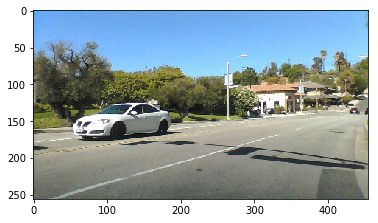

In [4]:
plt.imshow(img)
plt.show()

I convert the image in HSV (hue saturation value) in order to easily modify its brightness.

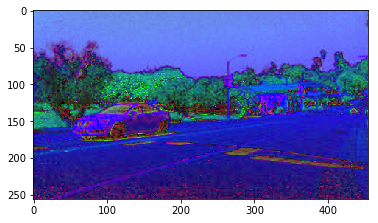

In [5]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(hsv)
plt.show()

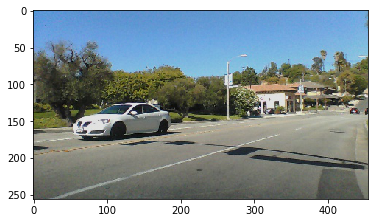

In [6]:
rand = random.uniform(0.3,1.6)
hsv[:,:,2] = rand*hsv[:,:,2]
new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
plt.imshow(new_img)
plt.show()

Then, I cut the upper part of the image, that in all cases is just sky and buildings, and doesn't add up information about the steering angle, while making the input bigger.

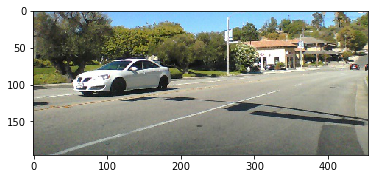

In [7]:
crop_img = img[60::, ::]
plt.imshow(crop_img)
plt.show()

I write the previous steps as functions to easily call them.

In [8]:
def change_bright(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    rand = random.uniform(0.5,1.)
    hsv[:,:,2] = rand*hsv[:,:,2]
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
   # plt.imshow(new_img)
   # plt.show()
    return new_img

In [9]:
change_bright(img)

array([[[ 39,  79, 119],
        [ 40,  79, 118],
        [ 43,  87, 121],
        ..., 
        [ 63,  94, 107],
        [ 62,  90, 106],
        [ 61,  86, 108]],

       [[ 37,  78, 118],
        [ 44,  86, 123],
        [ 43,  87, 121],
        ..., 
        [ 66,  97, 113],
        [ 59,  88, 107],
        [ 60,  90, 112]],

       [[ 40,  80, 119],
        [ 44,  83, 122],
        [ 44,  85, 120],
        ..., 
        [ 67,  97, 120],
        [ 57,  88, 111],
        [ 60,  92, 116]],

       ..., 
       [[ 44,  48,  44],
        [ 47,  50,  47],
        [ 49,  50,  50],
        ..., 
        [ 65,  67,  59],
        [ 64,  68,  59],
        [ 65,  69,  60]],

       [[ 42,  49,  49],
        [ 43,  49,  48],
        [ 45,  50,  46],
        ..., 
        [ 64,  66,  59],
        [ 63,  66,  59],
        [ 65,  69,  61]],

       [[ 42,  49,  53],
        [ 43,  50,  50],
        [ 46,  51,  47],
        ..., 
        [ 62,  64,  59],
        [ 62,  65,  59],
        [ 65,  68,

In [11]:
def crop_sky(img):
    
    crop_img = img[60::, ::]
   # plt.imshow(crop_img)
   # plt.show()
    return crop_img


In [12]:
crop_sky(img)

array([[[130, 143, 133],
        [121, 136, 143],
        [113, 129, 145],
        ..., 
        [159, 223, 248],
        [157, 219, 242],
        [164, 222, 246]],

       [[115, 134, 128],
        [123, 134, 136],
        [121, 130, 137],
        ..., 
        [156, 203, 213],
        [171, 216, 222],
        [177, 218, 224]],

       [[122, 140, 152],
        [117, 130, 138],
        [132, 142, 144],
        ..., 
        [216, 235, 239],
        [206, 225, 223],
        [208, 223, 218]],

       ..., 
       [[ 87,  94,  86],
        [ 93,  98,  92],
        [ 97,  99,  98],
        ..., 
        [128, 132, 117],
        [126, 133, 115],
        [129, 136, 118]],

       [[ 82,  96,  97],
        [ 85,  97,  95],
        [ 88,  98,  90],
        ..., 
        [126, 130, 116],
        [124, 130, 116],
        [128, 135, 119]],

       [[ 84,  97, 105],
        [ 84,  98,  98],
        [ 90, 100,  92],
        ..., 
        [122, 125, 116],
        [122, 128, 116],
        [127, 133,

Now I load the dataset. In the data.txt file we have the paths and steering angles of each picture.

In [14]:
data_path="/home/norman/Desktop/driving_dataset/data.txt"

Retrieve paths of images

In [15]:
img_paths=[]
steers=[]
with open(data_path) as file:
    for line in file:
        if line.split(',')[0] == "center": continue
        img_paths.append("/home/norman/Desktop/driving_dataset/" + line.split(' ')[0])
        steers.append(line.split(' ')[1].strip())

Here I split the dataset into training and validation sets, with a 1:10 ratio.

In [16]:
img_paths, img_valid, steers, steers_valid = train_test_split(img_paths, steers, test_size = 0.10, random_state = 100) 

Here we can see 10 examples extracted from the dataset.

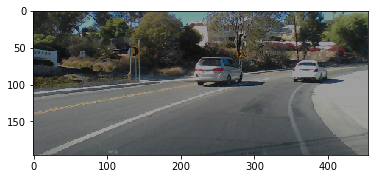

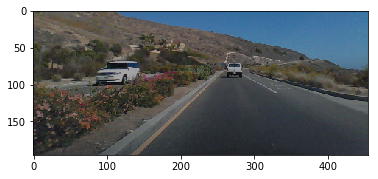

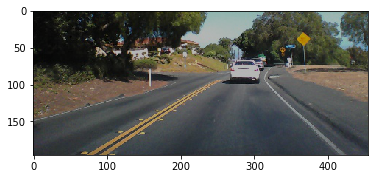

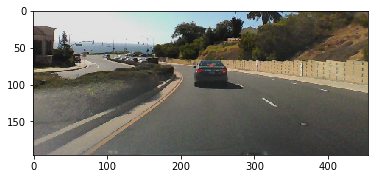

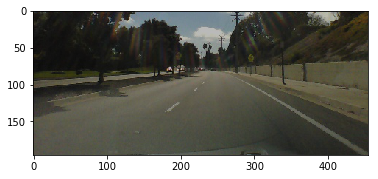

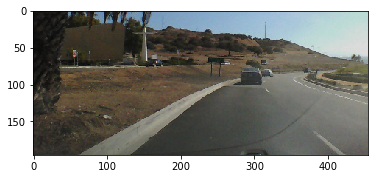

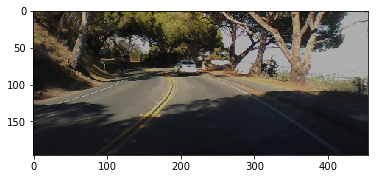

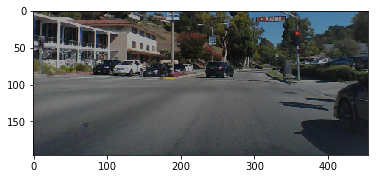

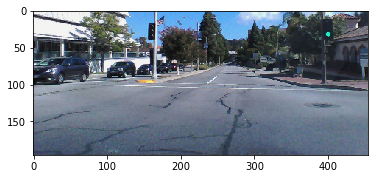

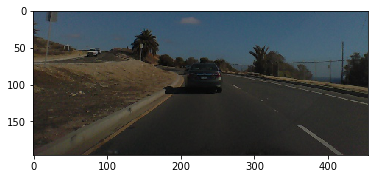

In [17]:
for i in range(10):
    img=plt.imread(img_paths[i])
    new=crop_sky(change_bright(img))
    plt.imshow(new)
    plt.show()

The images dataset is clearly too big to be loaded into the memory. So, I implemented a generator which yields from the dataset a number of images equal to the selected batch size. Equally, I define a validation generator.

In [18]:
def gen_batch(batch_size):
    batch_x=np.zeros((batch_size,196,455,3))
    batch_y=np.zeros((batch_size,1))
    pointer=0
    (im_paths, steerss)=shuffle(img_paths, steers)
    while True:
        for i in range(batch_size):
            img=plt.imread(im_paths[pointer])
            steer=steerss[pointer]
            new_img=crop_sky(change_bright(img))
            
            batch_x[i]=new_img
            batch_y[i]=steer
            pointer+=1
            if pointer==len(im_paths)-1: pointer=0
        
        yield batch_x, batch_y

In [19]:
def gen_val_batch(batch_size):
    batch_x=np.zeros((batch_size,196,455,3))
    batch_y=np.zeros((batch_size,1))
    pointer=0
    (im_valid, steer_valid)=shuffle(img_valid, steers_valid)
    while True:
        for i in range(batch_size):
            img=plt.imread(im_valid[pointer])
            steer=steer_valid[pointer]
            new_img=crop_sky(change_bright(img))
            
            batch_x[i]=new_img
            batch_y[i]=steer
            pointer+=1
            if pointer==len(im_valid)-1: pointer=0
        
        yield batch_x, batch_y

In [23]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU, concatenate, GlobalAveragePooling2D, Input
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
import math

Using TensorFlow backend.


Here I defined the first model, the NVIDIA model, described in the relative paper. (see References in the report)
It's a CNN with an usual strucuture: a first convolutional part which extracts features, and a densely connected last part which finally outputs the steering angle.
Th batch size is 16, while the optimizer is Adam, with mean-squared error as loss function.
As it can be seen, it has around 500.000 parameters.

In [27]:
generator=gen_batch(16)
val_gen=gen_val_batch(16)
input_shape = (196,455,3)
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape = input_shape))
model.add(Convolution2D(24, (5, 5), padding='valid', strides =(2,2), kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(Convolution2D(36, (5, 5), padding='valid', strides =(2,2), kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(Convolution2D(48, (5, 5), padding='valid', strides = (2,2), kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same', strides = (2,2), kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='valid', strides = (2,2), kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(80, kernel_regularizer = l2(0.001)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(40, kernel_regularizer = l2(0.001)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(16, kernel_regularizer = l2(0.001)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(10, kernel_regularizer = l2(0.001)))
model.add(Dense(1, kernel_regularizer = l2(0.001)))
adam = Adam(lr = 0.0001)
model.compile(optimizer= adam, loss='mse')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 196, 455, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 226, 24)       1824      
_________________________________________________________________
activation_17 (Activation)   (None, 96, 226, 24)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 111, 36)       21636     
_________________________________________________________________
activation_18 (Activation)   (None, 46, 111, 36)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 21, 54, 48)        43248     
_________________________________________________________________
activation_19 (Activation)   (None, 21, 54, 48)        0         
__________

In [ ]:
history= model.fit_generator(generator, steps_per_epoch = int(len(img_paths)/4-10), epochs=10, validation_data=val_gen, validation_steps = 50)

Now I implement the SqueezeNet model, a new and intersting architecture which achieves remarkable classification accuracy with very few parameters.
Anyway, the object classification task needs the extraction of quite complicted patterns, while the driving task requires fewer different patterns to recognize road shape and cars, thus I reduced the number of filters, lowering even more the parameters number.
The last part is modified aswell to accomplish the regression task.

In [31]:
generator=gen_batch(16)
val_gen=gen_val_batch(16)
input_shape = (196,455,3)

The Fire module is the main building block of the network. I used the Keras Functional API instead of Sequential because this architecture is more complex, with data that splits into different filters and then gets again concatenated.

In [42]:
def fire(x, squeeze=16, expand=64):
    x = Convolution2D(squeeze, (1,1), padding='valid')(x)
    x = Activation('relu')(x)
    
    left = Convolution2D(expand, (1,1), padding='valid')(x)
    left = Activation('relu')(left)
    
    right = Convolution2D(expand, (3,3), padding='same')(x)
    right = Activation('relu')(right)
    
    x = concatenate([left, right], axis=3)
    return x

In [43]:
img_input=Input(shape=input_shape)

x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid')(img_input)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=16, expand=16)
x = fire(x, squeeze=16, expand=16)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=32, expand=32)
x = fire(x, squeeze=32, expand=32)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=48, expand=48)
x = fire(x, squeeze=48, expand=48)
x = fire(x, squeeze=64, expand=64)
x = fire(x, squeeze=64, expand=64)
x = Dropout(0.5)(x)

x = Convolution2D(5, (1, 1), padding='valid')(x) #forse pochi 5
x = Activation('relu')(x)
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)

x = Dense(1)(x)
out = Activation('linear')(x)

modelsqueeze= Model(img_input, out)

The model has very few parameters, around 180.000, thus being very light on memory and very fast for real-time inference.

In [44]:
adam = Adam(lr = 0.0001)
modelsqueeze.compile(optimizer= adam, loss='mse')
modelsqueeze.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 196, 455, 3)   0                                            
____________________________________________________________________________________________________
conv2d_42 (Conv2D)               (None, 97, 227, 64)   1792        input_2[0][0]                    
____________________________________________________________________________________________________
activation_52 (Activation)       (None, 97, 227, 64)   0           conv2d_42[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)   (None, 48, 113, 64)   0           activation_52[0][0]              
___________________________________________________________________________________________

In [ ]:
history= modelsqueeze.fit_generator(generator, steps_per_epoch = int(len(img_paths)/4-10), epochs=10, validation_data=val_gen, validation_steps = 50)

If needed, here we can save the model.

In [ ]:

model_json = modelsqueeze.to_json()
with open("modelsqueeze.json", "w") as json_file:
    json_file.write(model_json)

modelsqueeze.save_weights("modelsqueeze.h5")

In [32]:
from keras.models import model_from_json
import json
json_data=open("modelnvidia.json", "r").read()

    
model = model_from_json(json_data)
model.load_weights("modelnvidia.h5")
model.compile(optimizer= adam, loss='mse')


In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 196, 455, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 226, 24)       1824      
_________________________________________________________________
activation_6 (Activation)    (None, 96, 226, 24)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 111, 36)       21636     
_________________________________________________________________
activation_7 (Activation)    (None, 46, 111, 36)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 54, 48)        43248     
_________________________________________________________________
activation_8 (Activation)    (None, 21, 54, 48)        0         
__________

In [29]:
model.load_weights("modelsqueeze.h5")
model.compile(optimizer= adam, loss='mse')


In [34]:
model.evaluate_generator(val_gen,steps=100)

125.33243351221084